<a href="https://colab.research.google.com/github/erikjskie/ensemblemerge_manuscript/blob/main/Supplementarty_Fig4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### install R packages ###
install.packages("devtools")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(c("SummarizedExperiment", "SingleCellExperiment", "knitr", "LoomExperiment", "batchelor"))
devtools::install_github("immunogenomics/harmony")
devtools::install_github('theislab/kBET')
devtools::install_version("Seurat", version = "4.0.1")
remotes::install_github('satijalab/seurat-wrappers@66e6e5096e1d6291cb5a735f3e266336c16e80c4')
devtools::install_github("cellgeni/sceasy")
install.packages("rliger")
install.packages("rstudio/reticulate")
install.packages("SparseM")
install.packages("ArgumentCheck")
install.packages("ggpubr")
### load in python packages (if not installed, can be installed by package)
system("pip3 install scanpy")
system("pip3 install scanorama")
system("pip3 install bbknn")
system("pip3 install pynndescent")
system("pip3 install leidenalg")
system("pip3 install scvi-tools")
devtools::install_github("erikjskie/ensemblemerge")
devtools::install_github('gongx030/scmetrics@b26a37c7e8b2f50b58f7b14e7f4748a805a1cf80', quiet = FALSE, ref = 'master')
devtools::reload(pkgload::inst("scmetrics"))

In [ ]:
library(ensemblemerge)
library(scmetrics)
library(Seurat)
library(dplyr)
library(SeuratWrappers)
library(magrittr)
library(ggplot2)
library(ggpubr)

In [ ]:
system("wget -x -c -nH https://s3.msi.umn.edu/skiex003/datasets/dataset=JC_benchmark_scRNAseq_version=2021219a/dataset_8_DS.rds")
data = readRDS("/content/skiex003/datasets/dataset=JC_benchmark_scRNAseq_version=2021219a/dataset_8_DS.rds")
data = as(data, "SingleCellExperiment")
keep_feature <- rowSums(counts(data) > 0) > 0
data <- data[keep_feature, ]
data <- as.Seurat(data, data = NULL)
Idents(data) = "batch"
#data <- subset(data, downsample = 5000)
data

In [ ]:
#running uncorrected results
params = setParams(method = "Uncorrected", return = "Seurat")
uncorrected = Merge(params, data)
uncorrected <- RunUMAP(uncorrected, reduction = "pca", dims = 1:20, seed.use = 1)
uncorrected <- FindNeighbors(uncorrected, reduction = 'umap', dims = 1:2, verbose = FALSE)
uncorrected <- FindClusters(uncorrected, algorithm = 3, resolution = 0.01, verbose = FALSE)
uncorrected$cluster <- Idents(uncorrected)

#running Harmony results
params = setParams(method = "Harmony", return = "Seurat")
Harmony = Merge(params, data)
Harmony <- RunUMAP(Harmony, reduction = "harmony", dims = 1:20, seed.use = 1)
Harmony <- FindNeighbors(Harmony, reduction = 'umap', dims = 1:2, verbose = FALSE)
Harmony <- FindClusters(Harmony, algorithm = 3, resolution = 0.01, verbose = FALSE)
Harmony$cluster <- Idents(Harmony)

#running Seurat results
params = setParams(method = "Seurat", return = "Seurat")
Seurat = Merge(params, data)
Seurat <- RunUMAP(Seurat, reduction = "pca", dims = 1:20, seed.use = 1)
Seurat <- FindNeighbors(Seurat, reduction = 'umap', dims = 1:2, verbose = FALSE)
Seurat <- FindClusters(Seurat, algorithm = 3, resolution = 0.01, verbose = FALSE)
Seurat$cluster <- Idents(Seurat)

#running BBKNN results
params = setParams(method = "BBKNN", return = "Seurat")
BBKNN = Merge(params, data)
BBKNN <- RunUMAP(BBKNN, nn.name = "bbknn", seed.use = 1)
BBKNN <- FindNeighbors(BBKNN, reduction = 'umap', dims = 1:2, verbose = FALSE)
BBKNN <- FindClusters(BBKNN, algorithm = 3, resolution = 0.01, verbose = FALSE)
BBKNN$cluster <- Idents(BBKNN)

#running ensemblemerge results
test = EnsembleMerge(data, methods = c("Seurat", "Harmony", "BBKNN"), return = "Seurat", file = "Dataset_1.csv")
test = RunUMAP(test, graph = "EnsembleMerge")
test <- FindNeighbors(test, reduction = 'umap', dims = 1:2, verbose = FALSE)
test <- FindClusters(test, algorithm = 3, resolution = 0.01, verbose = FALSE)

In [ ]:
uncorrected = as.SingleCellExperiment(uncorrected)
Seurat = as.SingleCellExperiment(Seurat)
Harmony = as.SingleCellExperiment(Harmony)
BBKNN = as.SingleCellExperiment(BBKNN)
test = as.SingleCellExperiment(test)

In [ ]:
config <- list(
  label_field = "CellType",
  batch_field = "batch",
  n_neighbors = 15L,
  resolution_min = 1e-3,
  resolution_max = 1,
  resolution_length = 40L,
  metrics_max = c('ARI')
) %>%
  expand.grid(stringsAsFactors = FALSE)

ARGS<- config[1, ]

params <- new('ClusterLouvain', n_neighbors = ARGS[['n_neighbors']], resolution_min = ARGS[['resolution_min']], resolution_max = ARGS[['resolution_max']], resolution_length = ARGS[['resolution_length']])

r <- 'UMAP'

names = c("Uncorrected", "EnsembleMerge", "Seurat", "Harmony", "BBKNN")
i = 1

nmi_list = list()
ari_cell_list = list()
ari_batch_list = list()
asw_cell_list = list()
asw_batch_list = list()

for(tests in list(uncorrected, test, Seurat, Harmony, BBKNN)){
  tests <- suppressWarnings(cluster_cells(tests, params, reduction = r, label=  ARGS[['label_field']], cluster = 'cluster', metric = ARGS[['metrics_max']]))
  nmi <- metrics(tests, new('MetricsNMI'), label = ARGS[['label_field']], cluster = 'cluster')
  nmi_list = append(nmi_list, nmi)
  ari_cell <- metrics(tests, new('MetricsARI'), label = ARGS[['label_field']], cluster = 'cluster')
  ari_cell_list = append(ari_cell_list, ari_cell)
  ari_batch <- metrics(tests, new('MetricsARI'), label = ARGS[['batch_field']], cluster = 'cluster')
  ari_batch <- 1 - ari_batch
  ari_batch_list = append(ari_batch_list, ari_batch)
  asw_cell <- metrics(tests, new('MetricsASW'), label = ARGS[['label_field']], reduction = r)
  asw_cell <- (asw_cell + 1) / 2
  asw_cell_list = append(asw_cell_list, asw_cell)
  asw_batch <- metrics(tests, new('MetricsASW'), label = ARGS[['batch_field']], reduction = r)
  asw_batch <- 1 - abs(asw_batch)
  asw_batch_list = append(asw_batch_list, asw_batch)
  sprintf('%s Score:', names[i]) %>% message()
  sprintf('NMI: %.3f', nmi) %>% message()
  sprintf('ARI(cell): %.3f', ari_cell) %>% message()
  sprintf('ASW(cell): %.3f', asw_cell) %>% message()
  sprintf('ARI(batch): %.3f', ari_batch) %>% message()
  sprintf('ASW(batch): %.3f', asw_batch) %>% message()
  i = i + 1
}

names(ari_cell_list) = names
names(nmi_list) = names
names(ari_cell_list) = names
names(ari_batch_list) = names
names(asw_cell_list) = names
names(asw_batch_list) = names

nmi_list = as.data.frame(nmi_list)
ari_cell_list = as.data.frame(ari_cell_list)
ari_batch_list = as.data.frame(ari_batch_list)
asw_cell_list = as.data.frame(asw_cell_list)
asw_batch_list = as.data.frame(asw_batch_list)

nmi_list = t(nmi_list)
ari_cell_list = t(ari_cell_list)
ari_batch_list = t(ari_batch_list)
asw_cell_list = t(asw_cell_list)
asw_batch_list = t(asw_batch_list)

colnames(ari_cell_list) = c("score")
colnames(nmi_list) = c("score")
colnames(ari_batch_list) = c("score")
colnames(asw_cell_list) = c("score")
colnames(asw_batch_list) = c("score")

nmi_list = as.data.frame(nmi_list)
ari_cell_list = as.data.frame(ari_cell_list)
ari_batch_list = as.data.frame(ari_batch_list)
asw_cell_list = as.data.frame(asw_cell_list)
asw_batch_list = as.data.frame(asw_batch_list)

nmi_list$score_method = "NMI"
ari_cell_list$score_method = "ARI_Cell"
ari_batch_list$score_method = "ARI_Batch"
asw_cell_list$score_method = "ASW_Cell"
asw_batch_list$score_method = "ASW_Batch"

nmi_list$method = rownames(nmi_list)
ari_cell_list$method = rownames(ari_cell_list)
ari_batch_list$method = rownames(ari_batch_list)
asw_cell_list$method = rownames(asw_cell_list)
asw_batch_list$method = rownames(asw_batch_list)

nmi_list = nmi_list[order(-nmi_list$score),]
ari_cell_list = ari_cell_list[order(-ari_cell_list$score),]
ari_batch_list = ari_batch_list[order(-ari_batch_list$score),]
asw_cell_list = asw_cell_list[order(-asw_cell_list$score),]
asw_batch_list = asw_batch_list[order(-asw_batch_list$score),]

scores = list(nmi_list, ari_cell_list, ari_batch_list, asw_cell_list, asw_batch_list)
scores = Reduce(rbind, scores)
scores

In [ ]:
test = as.Seurat(test)
uncorrected = as.Seurat(uncorrected)
Seurat = as.Seurat(Seurat, counts = "logcounts")
Harmony = as.Seurat(Harmony)
BBKNN = as.Seurat(BBKNN)

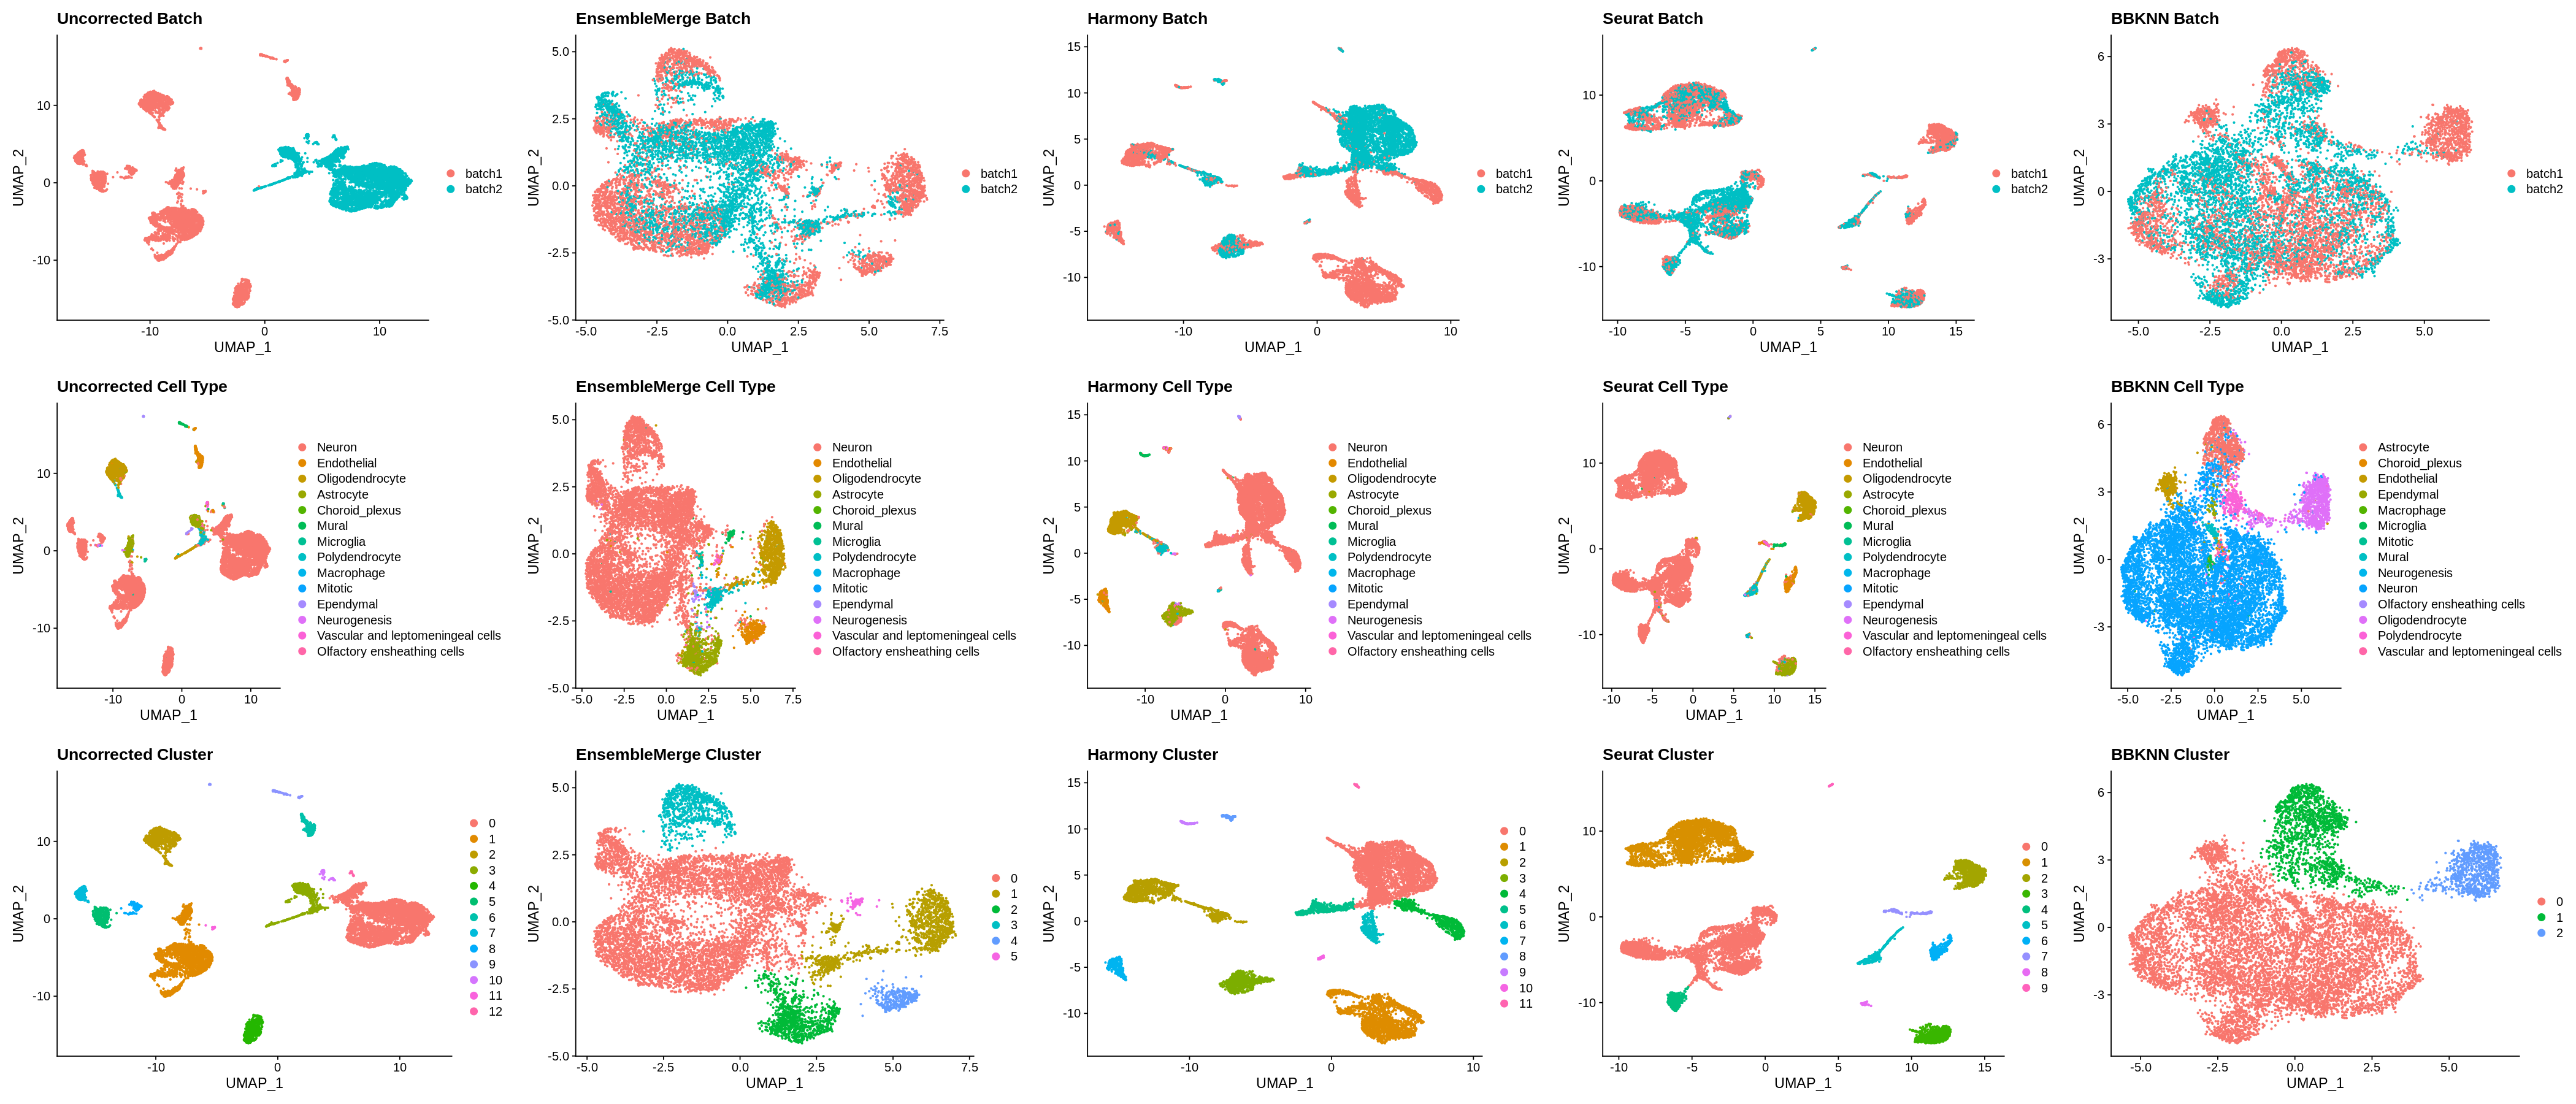

In [ ]:
options(repr.plot.width = 35, repr.plot.height = 15)
Seurat::Idents(uncorrected) = "batchlb"
p1 <- Seurat::DimPlot(uncorrected, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Uncorrected Batch")
Seurat::Idents(uncorrected) = "CellType"
p2 <- Seurat::DimPlot(uncorrected, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Uncorrected Cell Type")
Seurat::Idents(uncorrected) = "cluster"
p3 <- Seurat::DimPlot(uncorrected, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Uncorrected Cluster")
Seurat::Idents(test) = "batchlb"
p4 <- Seurat::DimPlot(test, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "EnsembleMerge Batch")
Seurat::Idents(test) = "CellType"
p5 <- Seurat::DimPlot(test, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "EnsembleMerge Cell Type")
Seurat::Idents(test) = "seurat_clusters"
p6 <- Seurat::DimPlot(test, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "EnsembleMerge Cluster")
Seurat::Idents(Harmony) = "batchlb"
p7 <- Seurat::DimPlot(Harmony, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Harmony Batch")
Seurat::Idents(Harmony) = "CellType"
p8 <- Seurat::DimPlot(Harmony, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Harmony Cell Type")
Seurat::Idents(Harmony) = "cluster"
p9 <- Seurat::DimPlot(Harmony, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Harmony Cluster")
Seurat::Idents(Seurat) = "batchlb"
p10 <- Seurat::DimPlot(Seurat, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Seurat Batch")
Seurat::Idents(Seurat) = "CellType"
p11 <- Seurat::DimPlot(Seurat, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Seurat Cell Type")
Seurat::Idents(Seurat) = "cluster"
p12 <- Seurat::DimPlot(Seurat, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "Seurat Cluster")
Seurat::Idents(BBKNN) = "batchlb"
p13 <- Seurat::DimPlot(BBKNN, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "BBKNN Batch")
Seurat::Idents(BBKNN) = "CellType"
p14 <- Seurat::DimPlot(BBKNN, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "BBKNN Cell Type")
Seurat::Idents(BBKNN) = "cluster"
p15 <- Seurat::DimPlot(BBKNN, reduction = "UMAP", pt.size = 0.5, shuffle = TRUE) + ggplot2::ggtitle(label = "BBKNN Cluster")
ggarrange(p1,p4,p7,p10,p13,p2,p5,p8,p11,p14,p3,p6,p9,p12,p15,
          ncol = 5, nrow = 3)

In [ ]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scmetrics_0.0.02            SingleCellExperiment_1.16.0
 [3] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [5] GenomicRanges_1.46.0        GenomeInfoDb_1.30.0        
 [7] IRanges_2.28.0              S4Vectors_0.32.2           
 [9] BiocGen